In [52]:
# Loading Python libraries

# Data manipulation libraries
import numpy as np
import pandas as pd

# Machine learning libraries

# Metrics
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, roc_auc_score

# Data pre-processing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Outlier detection and feature selection
from scipy.stats import zscore
from sklearn.feature_selection import RFE, SelectFromModel

# Classification models
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier

# category_encoders
import category_encoders as ce

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib.pylab import rcParams

# Set maximum number of columns and column width for pandas
pd.set_option('display.max_columns', 85)
pd.set_option('max_colwidth', 400)
# Set global plotting parameters
rcParams['font.size'] = 18
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'
rcParams['axes.spines.right'] = 'False'
rcParams['axes.spines.top'] = 'False'

# Stack Overflow Developer Survey Data

## Introduction

The Stack Overflow Developer Survey is an anual survey conducted by Stackoverflow among it's users. The survey is comprised of questions about a range of aspect of a developer's work. The data is orgnanised in a way that each column is a survey question and each row contains the answers of one respondent to these questions. The aim is to build a supervised machine learning model to predict whether a developer works remotely or not (i.e., in their company offices) from characteristics of these developers.

In [2]:
# Import the data
df = pd.read_csv('survey_results_public.csv')

## 1. Load and inspect data

The option between working from home or in the office only applies to professional developers. Therefore, the analysis will be restricted to pressional developers.

In [3]:
# Select profesional developers
df_prof = df[df['MainBranch'] == 'I am a developer by profession']
print(df.shape)
df_prof.shape

(88883, 85)


(65679, 85)

In [4]:
# Delete MainBranch column because it has no predictive value anymore
del df_prof['MainBranch']

The variables "CurrencySymbol" and "CurrencyDesc" refer to the currency with the reposndants use day-to-day. This tightly linked to the countries the respondents reside in. Since, this information is redundant the culumns "CurrencySymbol" and "CurrencyDesc" can be deleted.

In [5]:
df_prof.drop(["CurrencySymbol", "CurrencyDesc"], axis=1, inplace=True)

In [6]:
# Inspect the number of categories per variable
df_prof.nunique().sort_values(ascending=False)[:20]

Respondent                65679
LanguageDesireNextYear    21363
LanguageWorkedWith        16003
DevType                   10192
PlatformDesireNextYear     9011
ConvertedComp              8662
PlatformWorkedWith         7617
DevEnviron                 5952
MiscTechDesireNextYear     4608
CompTotal                  3934
DatabaseDesireNextYear     3596
DatabaseWorkedWith         3253
MiscTechWorkedWith         2307
WebFrameDesireNextYear     2002
WebFrameWorkedWith         1985
EduOther                    483
WorkWeekHrs                 196
JobFactors                  175
Ethnicity                   170
Country                     170
dtype: int64

High cardinality feature are deleted to reduce computation time.

In [7]:
# Identify columns with more than 2,000 categories.
cat_col = pd.DataFrame(df_prof.nunique(), columns=['category'])
high_cat = cat_col[cat_col['category']>2000].index.to_list()
# Salary is still needed for analysis
high_cat.remove('ConvertedComp')
high_cat

['Respondent',
 'DevType',
 'CompTotal',
 'LanguageWorkedWith',
 'LanguageDesireNextYear',
 'DatabaseWorkedWith',
 'DatabaseDesireNextYear',
 'PlatformWorkedWith',
 'PlatformDesireNextYear',
 'WebFrameDesireNextYear',
 'MiscTechWorkedWith',
 'MiscTechDesireNextYear',
 'DevEnviron']

In [8]:
# Remove the columns with more than 2,000 categories
df_prof = df_prof.drop(high_cat, axis=1)
df_prof.shape

(65679, 69)

In [9]:
# Inspect the number of empty rows per column
df_prof.isna().sum().sort_values(ascending=False)[:30]

BlockchainOrg         23937
BlockchainIs          20461
CodeRevHrs            19084
ConvertedComp         15177
SONewContent          14959
SOHowMuchTime         14958
WebFrameWorkedWith    13339
MgrIdiot              11790
MgrMoney              11779
MgrWant               11718
PurchaseHow           10463
PurchaseWhat           9760
SOPartFreq             9084
UnitTests              8999
CompFreq               8559
Sexuality              8364
Ethnicity              8308
WorkWeekHrs            7514
Age                    6012
ScreenName             5820
UndergradMajor         5570
LastInt                4855
WorkChallenge          4345
Dependents             3676
WorkPlan               3662
OrgSize                3411
Trans                  3367
SOVisit1st             3208
SocialMedia            2886
EduOther               2827
dtype: int64

In [10]:
# Export variables with more than 3,000 empty rows
high_nan_df = pd.DataFrame(df_prof.nunique(), columns=['empty'])
high_nan_var = high_nan_df[high_nan_df['empty']>3_000].index.to_list()
# Retain some categories which might be relavant for remote working
high_nan_var = [e for e in high_nan_var if e not in ('ConvertedComp', 'WorkWeekHrs', 'Age', 'Dependents', 'WorkChallenge', 'OrgSize', 'Ethnicity')]

In [11]:
# Remove the columns with the most nan values
df_prof_na = df_prof.drop(high_nan_var, axis=1)

## 2. Modify Variables with Numeric Data in Order to Change Data Type to Numeric

In [12]:
# Show unique values in 'YearsCode' column
df_prof_na['YearsCode'].unique()

array(['3', '16', '6', '12', '17', '13', '10', '5', '14', '35', '2', '4',
       '30', '8', '9', '26', '19', '15', '7', '20', '28', '25', '1', '22',
       '11', '33', '50', '41', '18', '24', '23', '42', '27', '21', nan,
       '36', '32', 'Less than 1 year', '34', '39', '38', '40', '37', '31',
       '29', '44', '45', '48', '46', '43', '47', 'More than 50 years',
       '49'], dtype=object)

In [13]:
# Replace strings with appropriate numeric values
df_prof_na['YearsCode'] = df_prof_na['YearsCode'].replace(['Less than 1 year', 'More than 50 years'], [0, 51])

In [14]:
# Show unique values in 'YearsCodePro' column
df_prof_na['YearsCodePro'].unique()

array(['Less than 1 year', '9', '4', '10', '8', '2', '3', '13', '18', '1',
       '5', '14', '22', '23', '19', '20', '25', '7', '15', '27', '48',
       '12', '35', '31', '11', '6', '17', '16', '21', nan, '30', '26',
       '33', '37', '40', '29', '28', '34', '24', '39', '38', '36', '32',
       '45', '43', '44', '42', '41', 'More than 50 years', '46', '49',
       '50', '47'], dtype=object)

In [15]:
# Replace strings with appropriate numeric values
df_prof_na['YearsCodePro'] = df_prof_na['YearsCodePro'].replace(['Less than 1 year', 'More than 50 years'], [0, 51])

In [16]:
# # Show unique values in 'Age1stCode' column
df_prof_na['Age1stCode'].unique()

array(['16', '14', '17', '11', '20', '18', '13', '12', '19', '21', '8',
       '35', '10', '6', '15', '7', '9', '5', '23', '22', '30', '29', '27',
       '24', 'Younger than 5 years', '33', '25', '26', nan, '36', '28',
       '31', '32', '37', '50', '65', '34', '40', '43', '38', '51', '41',
       '55', '39', '83', '42', '45', 'Older than 85', '48', '44', '60',
       '79', '46', '49'], dtype=object)

In [17]:
# Replace strings with appropriate numeric values
df_prof_na['Age1stCode'] = df_prof_na['Age1stCode'].replace(['Younger than 5 years', 'Older than 85'], [4, 86])

In [18]:
# Recast the modified columns to numeric numeric data type
df_prof_na[['YearsCode', 'YearsCodePro', 'Age1stCode']] = df_prof_na[['YearsCode', 'YearsCodePro', 'Age1stCode']].apply(pd.to_numeric, axis=1, errors='coerce')

In [19]:
# Remove rows with empty values in any column
# df_prof_na.dropna(how='any', axis=0, inplace=True)
df_prof_na.dropna(axis=0, inplace=True)
df_prof_na.shape

(5487, 69)

If someone works from home less than once per month it can be considered as never. All the other answers are encoded as working from home.

In [20]:
# Create new column with dichotomised target variable
df_prof_na['Remote'] = np.where(df_prof_na['WorkRemote'] == 'Less than once per month / Never', 'Not remote', 'Remote')
df_prof_na[['Remote', 'WorkRemote']].sample(10)

Remote                                               WorkRemote
39817      Remote                                    A few days each month
37079  Not remote                         Less than once per month / Never
61222      Remote                                         It's complicated
18791      Remote                                    A few days each month
9968       Remote  Less than half the time, but at least one day each week
58269  Not remote                         Less than once per month / Never
20349      Remote                                    A few days each month
76696  Not remote                         Less than once per month / Never
87298      Remote                    More than half, but not all, the time
41821      Remote  Less than half the time, but at least one day each week

After creating a new column containing two classes of the target variable, the old target variable can be removed.

In [21]:
# Remove original target variable column
df_engi = df_prof_na.drop(['WorkRemote'], axis=1)
df_engi.shape

(5487, 69)

## 3. Outlier Detection

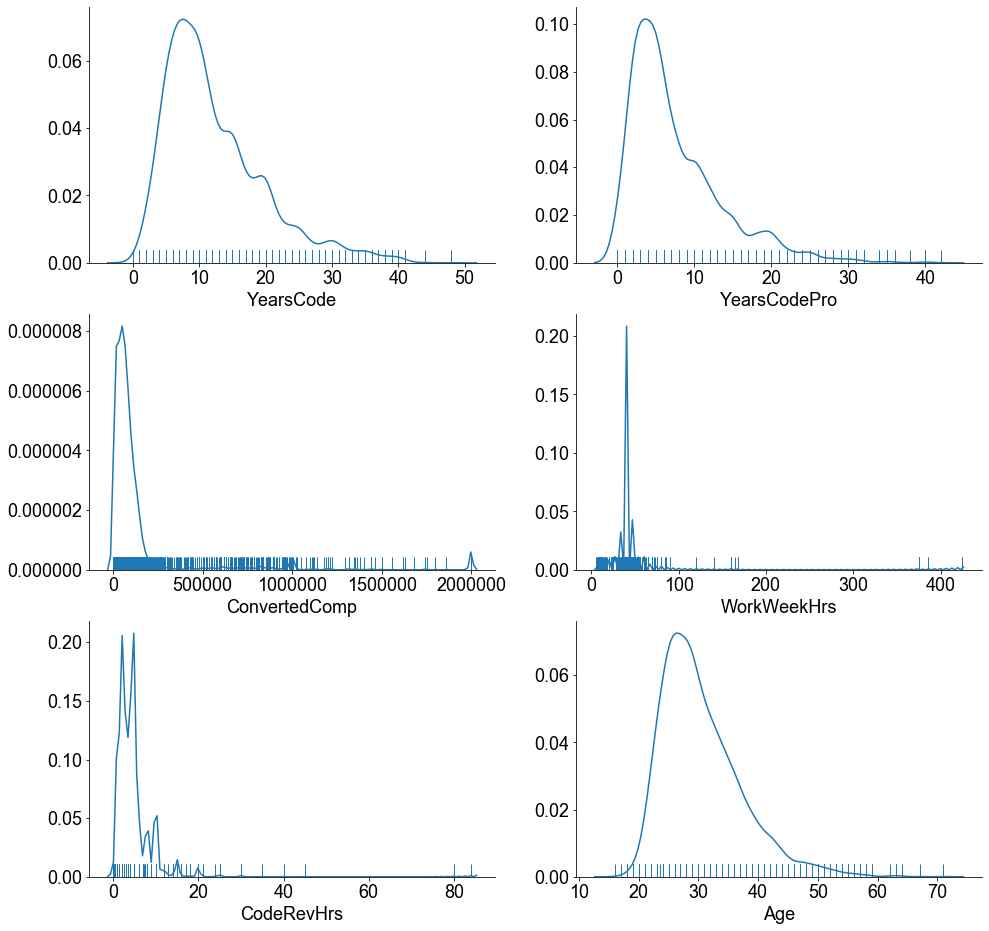

In [22]:
# Plot distribution of numeric features
num_col=['YearsCode','YearsCodePro','ConvertedComp','WorkWeekHrs','CodeRevHrs','Age']
# sns.set(rc={'figure.figsize':(16,16)})
fig, axs=plt.subplots(3,2)
fig.set_size_inches(16, 16)

for i,col in enumerate(num_col):
    row = i//2
    pos = i % 2

    plot = sns.distplot(df_engi[col], rug=True, hist=False, ax=axs[row][pos])

There seem to be many outliers in the ConvertedComp, WorkWeekHrs and CodeRevHrs columns. In order to remove these outliers these variables will be transformed to z-scores and all observations with an z-score equal or above 2.5 will be removed.

In [23]:
# Remove rows with z-score outliers in numeric columns
print(df_engi.shape)
df_engi = df_engi[list(abs(zscore(df_engi["ConvertedComp"])) < 2.5)]
df_engi = df_engi[list(abs(zscore(df_engi["WorkWeekHrs"])) < 2.5)] 
df_engi = df_engi[list(abs(zscore(df_engi["CodeRevHrs"])) < 2.5)]
df_engi.shape

(5487, 69)


(5092, 69)

The data of the YearsCode, YearsCodePro, ConvertedComp and Age variables are not normally distributed. To create normally distributed features the data from these variables will be log transformed.

In [24]:
# Define columns for log transformation
log_col = ['YearsCode','YearsCodePro','ConvertedComp','Age']
# Log transform numeric columns to create normal distribution
df_engi = df_engi.apply(lambda x: np.log(1+x) if x.name in log_col else x)

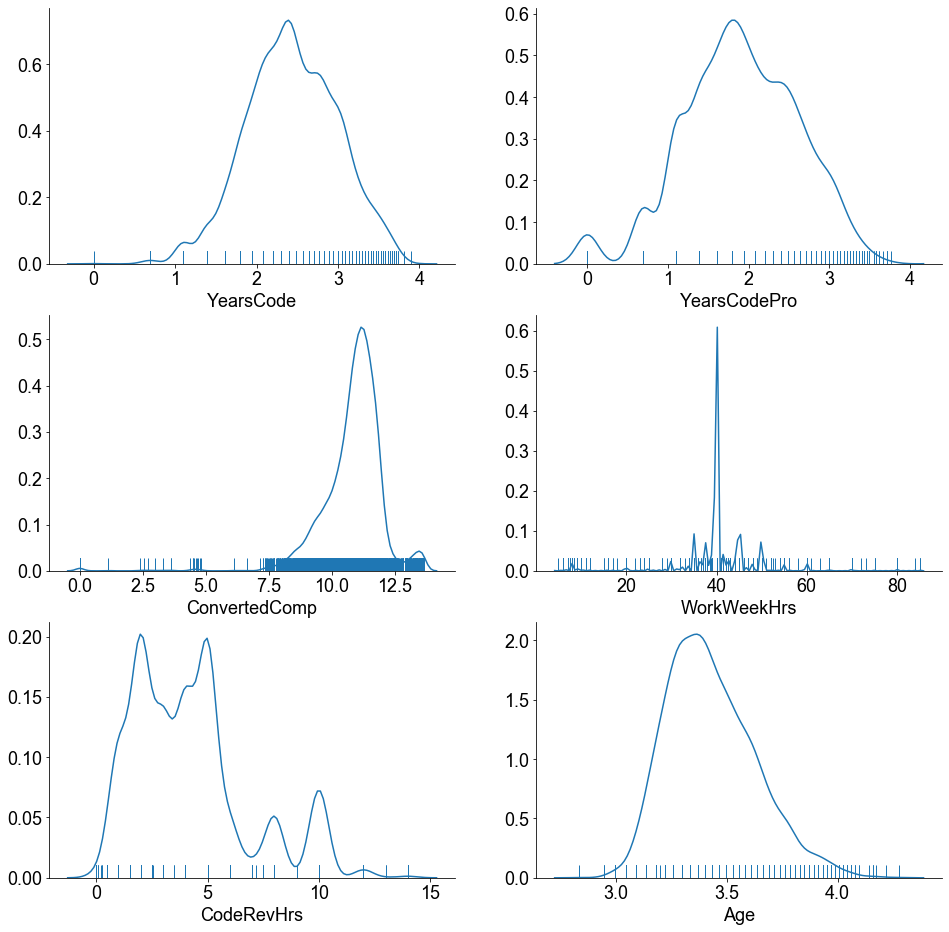

In [25]:
# Plot distribution of numeric features after outlier removal and log transformation
num_col=['YearsCode','YearsCodePro','ConvertedComp','WorkWeekHrs','CodeRevHrs','Age']
# sns.set(rc={'figure.figsize':(16,16)})
fig, axs=plt.subplots(3,2)
fig.set_size_inches(16, 16)

for i,col in enumerate(num_col):
    row = i//2
    pos = i % 2

    plot = sns.distplot(df_engi[col], rug=True, hist=False, ax=axs[row][pos])

In [26]:
df_fsel = df_engi.copy()
df_fsel.shape

(5092, 69)

## 4. Feature selection

In [27]:
# Replace categories in target variable with 0 and 1
df_fsel['Remote'] = df_fsel['Remote'].replace(['Not remote', 'Remote'], [0, 1])
df_fsel['Remote'].sample(10)

20809    1
50791    0
16719    0
77140    1
30287    0
9746     1
30622    1
55913    1
35648    1
40712    0
Name: Remote, dtype: int64

In [28]:
# Create lists with names of numeric and categorical columns
numcols = df_fsel.select_dtypes(include=['int64', 'float64']).columns
catcols = df_fsel.select_dtypes(include=['object']).columns

In [29]:
# Create training df with one-hot encoded categorical columns
traindf = pd.concat([df_fsel[numcols], pd.get_dummies(df_fsel[catcols])],axis=1)
traindf.head()

0   
55                                                                                          0   
75                                                                                          0   
82                                                                                          0   

    OpenSource_The quality of OSS and closed source software is about the same  \
38                                                                           1   
43                                                                           1   
55                                                                           1   
75                                                                           1   
82                                                                           0   

    Employment_Employed full-time  Employment_Employed part-time  \
38                              1                              0   
43                              1                              0   
55                              1                              0   
75                              1                              0   
82                              1                              0   

    Country_Albania  Country_Argentina  Country_Armenia  Country_Australia  \
38                0                  0                0                  0   
43                0                  0                0                  0   
55                0                  0                0                  0   
75                0                  0                0                  0   
82                0                  0                0                  0   

    Country_Austria  Country_Bangladesh  Country_Belarus  Country_Belgium  \
38                0                   0                0                0   
43                0                   0                0                0   
55                0                   0                0                0   
75                0                   0                0                0   
82                0                   0                0                0   

    Country_Bolivia  Country_Bosnia and Herzegovina  Country_Brazil  \
38                0                               0               0   
43                0                               0               0   
55                0                               0               0   
75                0                               0               0   
82                0                               0               0   

    Country_Bulgaria  Country_Cambodia  Country_Canada  Country_Chile  \
38                 0                 0               0              0   
43                 0                 0               0              0   
55                 0                 0               0              0   
75                 0                 0               0              0   
82                 0                 0               0              0   

    Country_China  Country_Colombia  Country_Costa Rica  Country_Croatia  \
38              0                 0                   0                0   
43              0                 0                   0                0   
55              1                 0                   0                0   
75              0                 0                   0                0   
82              0                 0                   0                0   

    Country_Cuba  Country_Cyprus  Country_Czech Republic  \
38             0               0                       0   
43             0               0                       0   
55             0               0                       0   
75             0               0                       0   
82             0               0                       0   

    Country_Côte d'Ivoire  ...  \
38                      0  ...   
43                      0  ...   
55                      0  ...   
75                      0  ...   
82             

In [30]:
# Define features and labels
X = traindf.copy()
del X['Remote']
y = traindf['Remote']

In [33]:
# Scale features
X_norm = MinMaxScaler().fit_transform(X)

In [31]:
feature_name = list(X.columns)
# Maximum number of features that can be selected
num_feats=40

In [34]:
# Recursive Feature Elimination
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 1881 features.
Fitting estimator with 1871 features.
Fitting estimator with 1861 features.
Fitting estimator with 1851 features.
Fitting estimator with 1841 features.
Fitting estimator with 1831 features.
Fitting estimator with 1821 features.
Fitting estimator with 1811 features.
Fitting estimator with 1801 features.
Fitting estimator with 1791 features.
Fitting estimator with 1781 features.
Fitting estimator with 1771 features.
Fitting estimator with 1761 features.
Fitting estimator with 1751 features.
Fitting estimator with 1741 features.
Fitting estimator with 1731 features.
Fitting estimator with 1721 features.
Fitting estimator with 1711 features.
Fitting estimator with 1701 features.
Fitting estimator with 1691 features.
Fitting estimator with 1681 features.
Fitting estimator with 1671 features.
Fitting estimator with 1661 features.
Fitting estimator with 1651 features.
Fitting estimator with 1641 features.
Fitting estimator with 1631 features.
Fitting esti

In [35]:
# Display results from Recursive Feature Elimination

['YearsCodePro',
 'Country_Croatia',
 'Country_Hong Kong (S.A.R.)',
 'Country_Lebanon',
 'Country_Malta',
 'EduOther_Completed an industry certification program (e.g. MCPD);Taught yourself a new language, framework, or tool without taking a formal course;Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder);Participated in a hackathon',
 'EduOther_Participated in a full-time developer training program or bootcamp;Taken a part-time in-person course in programming or software development;Received on-the-job training in software development;Taught yourself a new language, framework, or tool without taking a formal course',
 'EduOther_Participated in a full-time developer training program or bootcamp;Taught yourself a new language, framework, or tool without taking a formal course;Participated in a hackathon',
 'EduOther_Taken a part-time in-person course in programming or software development;Completed an industry certification program (e.g. MCPD);Received on-th

In [36]:
# Lasso Regularisation
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')
embeded_lr_feature

40 selected features


['Country_Croatia',
 'Country_Hong Kong (S.A.R.)',
 'Country_Lebanon',
 'Country_Malta',
 'Country_Nepal',
 'Country_Singapore',
 'Country_Slovakia',
 'Country_Uruguay',
 'EduOther_Taken a part-time in-person course in programming or software development;Completed an industry certification program (e.g. MCPD);Taught yourself a new language, framework, or tool without taking a formal course;Contributed to open source software',
 'EduOther_Taken a part-time in-person course in programming or software development;Taught yourself a new language, framework, or tool without taking a formal course;Participated in a hackathon',
 'EduOther_Taken an online course in programming or software development (e.g. a MOOC);Participated in a full-time developer training program or bootcamp;Completed an industry certification program (e.g. MCPD);Received on-the-job training in software development;Taught yourself a new language, framework, or tool without taking a formal course;Participated in a hackathon

Although the feature selection algorithms found several categories with high predictive power for working remotely, the final class prediction below will be done with all of the remaining features.

In [56]:
df_final = df_engi.copy()
df_final.shape

(5092, 69)

## 6. Tune Model Performance with Different Methods of Category Encoding

In [57]:
# Split features into two seperate df for numerical and categorical data types
numeric_features = df_final.select_dtypes(include=['int64', 'float64']).columns
# Drop target variable from categorical feature set
categorical_features = df_final.select_dtypes(include=['object']).drop(['Remote'], axis=1).columns

In [58]:
# Define set of explanatory variables and target variable
X = df_final.drop('Remote', axis=1)
y = df_final['Remote']

In [59]:
# Transform target variable into binary class
y = LabelEncoder().fit_transform(y)

In [60]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [61]:
# Instantiate model
classifier = RandomForestClassifier(n_estimators=200, class_weight='balanced')

In [48]:
# List with catgegory encoders to be tested
encoder_list = [ce.backward_difference.BackwardDifferenceEncoder, 
               ce.basen.BaseNEncoder,
               ce.binary.BinaryEncoder,
                ce.cat_boost.CatBoostEncoder,
                ce.hashing.HashingEncoder,
                ce.helmert.HelmertEncoder,
                ce.james_stein.JamesSteinEncoder,
                ce.one_hot.OneHotEncoder,
                ce.leave_one_out.LeaveOneOutEncoder,
                ce.m_estimate.MEstimateEncoder,
                ce.ordinal.OrdinalEncoder,
                ce.sum_coding.SumEncoder,
                ce.target_encoder.TargetEncoder,
                ce.woe.WOEEncoder
                ]

In [62]:
for encoder in encoder_list:
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[('woe', encoder())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    
    model = pipe.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    print(encoder)
    print(f"1. Mean squared error: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"2. Precision: {precision_score(y_test, y_pred, average='macro'):.4f}")
    print(f"3. Recall: {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"4. F1 score: {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"5. ROC AUC: {roc_auc_score(y_test, y_pred):.4f}")

<class 'category_encoders.backward_difference.BackwardDifferenceEncoder'>
1. Mean squared error: 0.3827
2. Precision: 0.5934
3. Recall: 0.5760
4. F1 score: 0.5715
5. ROC AUC: 0.5760
<class 'category_encoders.basen.BaseNEncoder'>
1. Mean squared error: 0.3484
2. Precision: 0.6363
3. Recall: 0.6142
4. F1 score: 0.6135
5. ROC AUC: 0.6142
<class 'category_encoders.binary.BinaryEncoder'>
1. Mean squared error: 0.3778
2. Precision: 0.5999
3. Recall: 0.5844
4. F1 score: 0.5820
5. ROC AUC: 0.5844
<class 'category_encoders.cat_boost.CatBoostEncoder'>
1. Mean squared error: 0.3454
2. Precision: 0.6408
3. Recall: 0.6394
4. F1 score: 0.6400
5. ROC AUC: 0.6394
<class 'category_encoders.hashing.HashingEncoder'>
1. Mean squared error: 0.4151
2. Precision: 0.5635
3. Recall: 0.5608
4. F1 score: 0.5609
5. ROC AUC: 0.5608
<class 'category_encoders.helmert.HelmertEncoder'>
1. Mean squared error: 0.3857
2. Precision: 0.5908
3. Recall: 0.5786
4. F1 score: 0.5766
5. ROC AUC: 0.5786
<class 'category_encoders.

## 7. Conclusion
Using a random forrest classifier the best prediction is obtained in combination with a CatBoost categorical encoder (F1 score: 0.64 and ROC AUC: 0.64). The reason for the low model performance is propably two-fold. Firstly, even after removing the features with the most categories there were still many high cardinality categorical features left. A range of different categories encoders was tested to encode these features but none improved the model performace to a great extent. The set of categorical features used is a mix of various data types which would be best encoded with a specific encoder for each given data type. Secondly, the data set contains many missing values. It was decided to remove missing values since the majority of the features are categorical and could therefore not be imputed. After removing missing observations only ~7% of the initial data from professional developers remained. This severe reduction in data depth propably affected the model performance negatively.

Using two feature selection algorithms showed which features have the highest predictive power for working remotely.  One of the most predictive categories was 'JobFactors' which describes factors that are decisive in choosing a new employer. Two of the answers in this category, 'Flex time or a flexible schedule' and 'Remote work options' are directly related to remote working. Another factor associated with the work location was the answer 'Distracting work environment' in the 'WorkChallenge'category. This implies that develpopers who prefer a quiet work environment choose to work from home.

Overall, this suggests that the feature selection algorithms correcly found features that are important for predicting whether a developer regularly works from home.

Interestingly, the 'Dependents' category was not found to have high predictive value for remote working. One would assume that developers with care duties would prefer to work from home.